In [ ]:
import pandas as pd
import glob
from datetime import datetime
import matplotlib.pyplot as plt

In [23]:
# 1. Locate all DGA logs for 2025-05-03
log_files = glob.glob('../logs/dga_*_training_logs_2025050[3-4]_*.csv')
print(log_files)

['../logs/dga_prajjwal1-bert-small_training_logs_20250503_144826.csv', '../logs/dga_prajjwal1-bert-tiny_training_logs_20250503_163713.csv', '../logs/dga_google-electra-small-discriminator_training_logs_20250503_150256.csv', '../logs/dga_prajjwal1-bert-mini_training_logs_20250503_164020.csv', '../logs/dga_albert-base-v2_training_logs_20250503_164447.csv', '../logs/dga_google-mobilebert-uncased_training_logs_20250503_174157.csv', '../logs/dga_distilbert-base-uncased_training_logs_20250503_142722.csv', '../logs/dga_prajjwal1-bert-medium_training_logs_20250503_145342.csv', '../logs/dga_google-electra-base-discriminator_training_logs_20250503_172453.csv', '../logs/dga_distilbert-base-cased_training_logs_20250503_143755.csv']


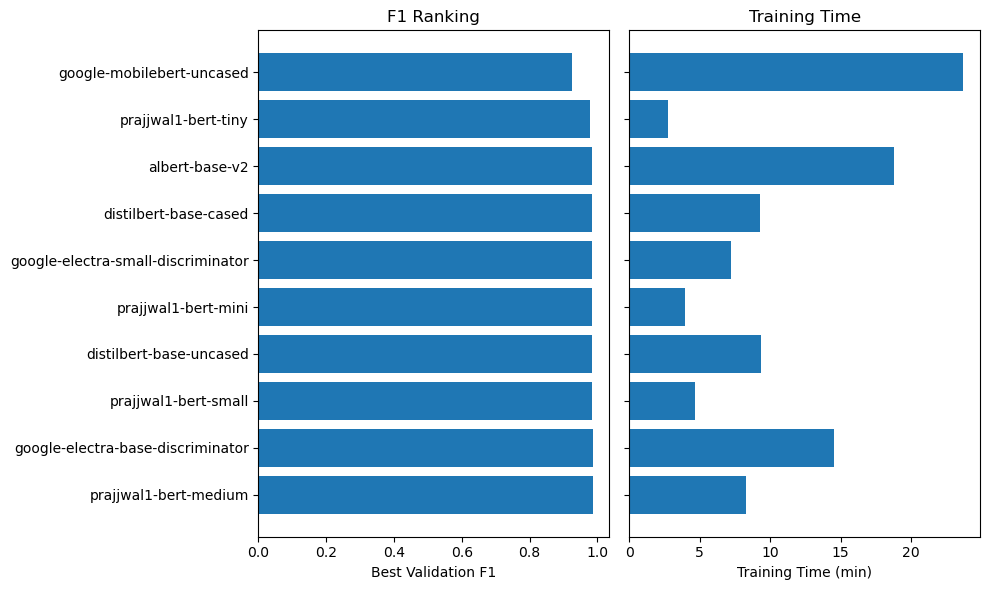

In [24]:
import pandas as pd
import glob
import matplotlib.pyplot as plt

# 1) Gather results
results = []
for file_path in log_files:
    filename   = file_path.split('/')[-1]
    parts      = filename.split('_')
    model_arch = parts[1]

    df = pd.read_csv(file_path, parse_dates=['timestamp'])
    best_idx = df['val_f1'].idxmax()
    best     = df.loc[best_idx]
    total_minutes = (df['timestamp'].max() - df['timestamp'].min()).total_seconds() / 60.0

    results.append({
        'model': model_arch,
        'best_epoch': int(best['epoch']),
        'val_f1': float(best['val_f1']),
        'val_acc': float(best['val_acc']),
        'val_precision': float(best['val_precision']),
        'val_recall': float(best['val_recall']),
        'training_time_min': total_minutes
    })

# 2) Create the DataFrame
res_df = pd.DataFrame(results)

# 3) Sort by best F1 descending
res_df = res_df.sort_values('val_f1', ascending=False).reset_index(drop=True)

# 4) Plot two horizontal bars side by side
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,6), sharey=True)

# Left: Best F1
ax1.barh(res_df['model'], res_df['val_f1'])
ax1.invert_yaxis()               # so the highest F1 is at the top
ax1.set_xlabel('Best Validation F1')
ax1.set_title('F1 Ranking')

# Right: Training time
ax2.barh(res_df['model'], res_df['training_time_min'])
ax2.invert_yaxis()               # keep same order
ax2.set_xlabel('Training Time (min)')
ax2.set_title('Training Time')

plt.tight_layout()
plt.show()


/tmp/ipykernel_1097655/910496995.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_f1.set_xticklabels(res_df['model'], rotation=45, ha='right')


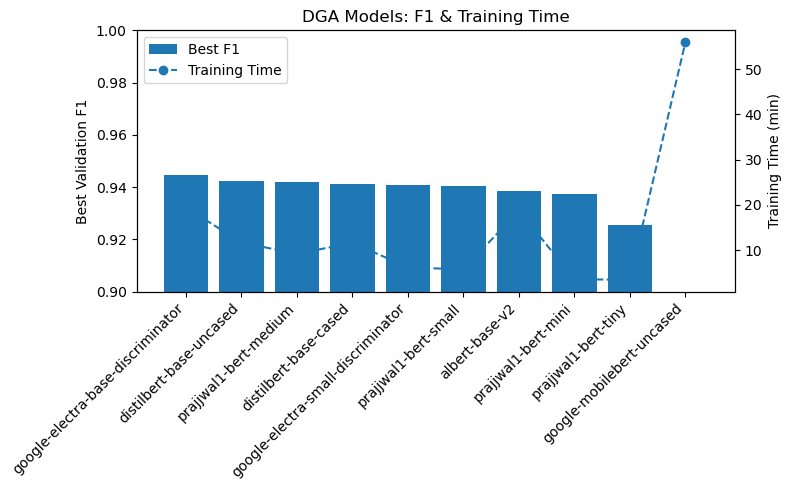

In [17]:
fig, ax_f1 = plt.subplots(figsize=(8,5))

# bar for F1
bars = ax_f1.bar(res_df['model'], res_df['val_f1'], label='Best F1')
ax_f1.set_ylabel('Best Validation F1')
ax_f1.set_ylim(0.9, 1.0)
ax_f1.set_xticklabels(res_df['model'], rotation=45, ha='right')

# twin axis for time
ax_time = ax_f1.twinx()
ax_time.plot(res_df['model'], res_df['training_time_min'], marker='o', linestyle='--', label='Training Time')
ax_time.set_ylabel('Training Time (min)')

# combine legends
lines, labels = ax_f1.get_legend_handles_labels()
lines2, labels2 = ax_time.get_legend_handles_labels()
ax_f1.legend(lines+lines2, labels+labels2, loc='upper left')

plt.title('DGA Models: F1 & Training Time')
plt.tight_layout()
plt.show()

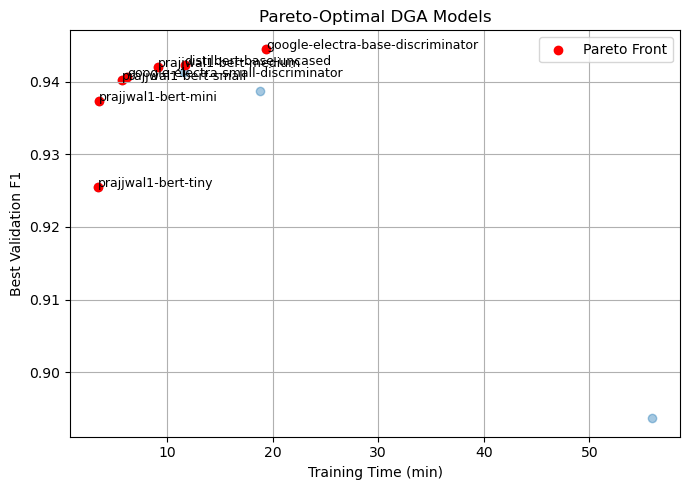

In [18]:
# Compute Pareto front (maximize F1, minimize time)
pareto = []
for i, ri in res_df.iterrows():
    dominated = any(
        (rj['val_f1'] >= ri['val_f1']) and (rj['training_time_min'] <= ri['training_time_min'])
        for j, rj in res_df.iterrows() if j != i
    )
    if not dominated:
        pareto.append(i)

plt.figure(figsize=(7,5))
plt.scatter(res_df['training_time_min'], res_df['val_f1'], alpha=0.4)
plt.scatter(
    res_df.loc[pareto, 'training_time_min'],
    res_df.loc[pareto, 'val_f1'],
    color='red',
    label='Pareto Front'
)
for i in pareto:
    row = res_df.loc[i]
    plt.text(row['training_time_min'], row['val_f1'], row['model'], fontsize=9)
plt.xlabel('Training Time (min)')
plt.ylabel('Best Validation F1')
plt.title('Pareto-Optimal DGA Models')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


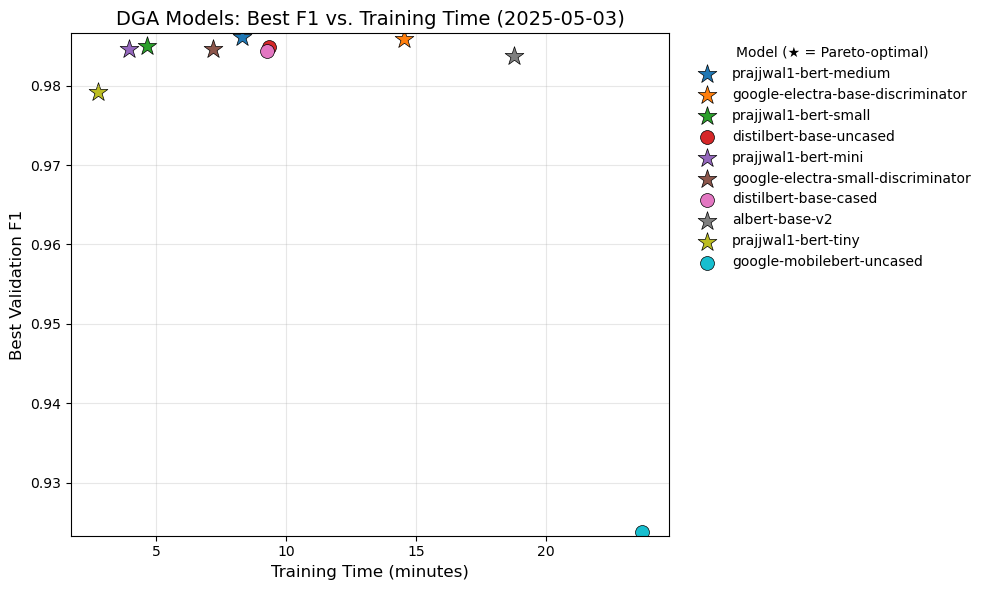

In [25]:
import matplotlib.pyplot as plt

# Assume res_df and pareto (list of dataframe indices) are already defined

# 1) Assign each model a unique color
models = res_df['model'].tolist()
unique_models = list(dict.fromkeys(models))  # preserve order
cmap = plt.get_cmap('tab10')
color_map = {m: cmap(i % cmap.N) for i, m in enumerate(unique_models)}

# 2) Plot
plt.figure(figsize=(10,6))
for idx, row in res_df.iterrows():
    m = row['model']
    is_pareto = idx in pareto
    plt.scatter(
        row['training_time_min'],
        row['val_f1'],
        color=color_map[m],
        marker='*' if is_pareto else 'o',
        s=200 if is_pareto else 100,
        edgecolor='black',
        linewidth=0.5,
        label=m  # one point per model → one legend entry per model
    )

# 3) Zoom the y-axis to just your F1 range ± padding
pad = 0.0005
plt.ylim(res_df['val_f1'].min() - pad, res_df['val_f1'].max() + pad)

# 4) Labels, title, grid
plt.xlabel('Training Time (minutes)', fontsize=12)
plt.ylabel('Best Validation F1', fontsize=12)
plt.title('DGA Models: Best F1 vs. Training Time (2025-05-03)', fontsize=14)
plt.grid(alpha=0.3)

# 5) Legend outside, to avoid covering points
plt.legend(
    title='Model (★ = Pareto-optimal)',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    frameon=False
)

plt.tight_layout()
plt.show()
